In [54]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = ['RELIANCE.NS', 'TATAMOTORS.NS','ICICIBANK.NS']
start_date = '2018-01-01'
end_date = '2024-12-31'

data = yf.download(tickers,start=start_date,end=end_date)['Close']
data = data.dropna()

weights = np.array([1/len(tickers)] * len(tickers))

daily_return = data.pct_change().dropna()
portfolio_returns = (daily_return * weights).sum(axis=1)

df = pd.DataFrame({'Portfolio_Return': portfolio_returns})

for lag in range(1,6):
    df[f'range_lag_{lag}'] = df['Portfolio_Return'].shift(lag)

# Feature: Rolling volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = df['Portfolio_Return'].rolling(window).std()

# Feature: Rolling mean return
for window in [5, 10, 20]:
    df[f'mean_return_{window}'] = df['Portfolio_Return'].rolling(window).mean()

# Target: Next-day volatility
df['target_volatility'] = df['Portfolio_Return'].rolling(window=5).std().shift(-1)

# Drop rows with NaN
df = df.dropna()

print(df.head())

[*********************100%***********************]  3 of 3 completed

            Portfolio_Return  range_lag_1  range_lag_2  range_lag_3  \
Date                                                                  
2018-01-30         -0.011812    -0.004268     0.004726    -0.025999   
2018-01-31          0.006613    -0.011812    -0.004268     0.004726   
2018-02-01         -0.017307     0.006613    -0.011812    -0.004268   
2018-02-02         -0.033020    -0.017307     0.006613    -0.011812   
2018-02-05          0.004284    -0.033020    -0.017307     0.006613   

            range_lag_4  range_lag_5  volatility_5  volatility_10  \
Date                                                                
2018-01-30     0.011192     0.015479      0.014529       0.013340   
2018-01-31    -0.025999     0.011192      0.013330       0.012783   
2018-02-01     0.004726    -0.025999      0.010321       0.013605   
2018-02-02    -0.004268     0.004726      0.014801       0.016921   
2018-02-05    -0.011812    -0.004268      0.016328       0.016404   

            volati

C:\Users\ov\AppData\Local\Temp\ipykernel_6504\3044003088.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ov\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


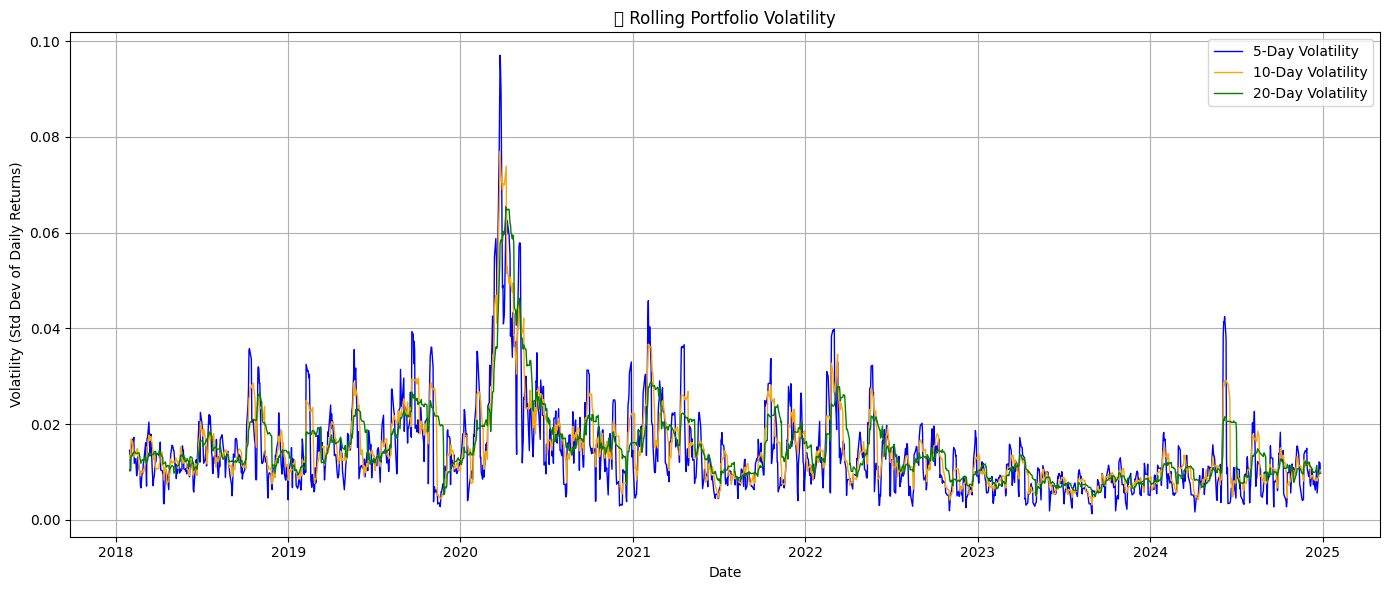

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(df.index, df['volatility_5'], label='5-Day Volatility', color='blue', linewidth=1)
plt.plot(df.index, df['volatility_10'], label='10-Day Volatility', color='orange', linewidth=1)
plt.plot(df.index, df['volatility_20'], label='20-Day Volatility', color='green', linewidth=1)

plt.title('📈 Rolling Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of Daily Returns)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(columns=['Portfolio_Return', 'target_volatility'])
y = df['target_volatility']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")


Model Evaluation
R² Score: 0.628
MAE: 0.002026
MSE: 0.000010


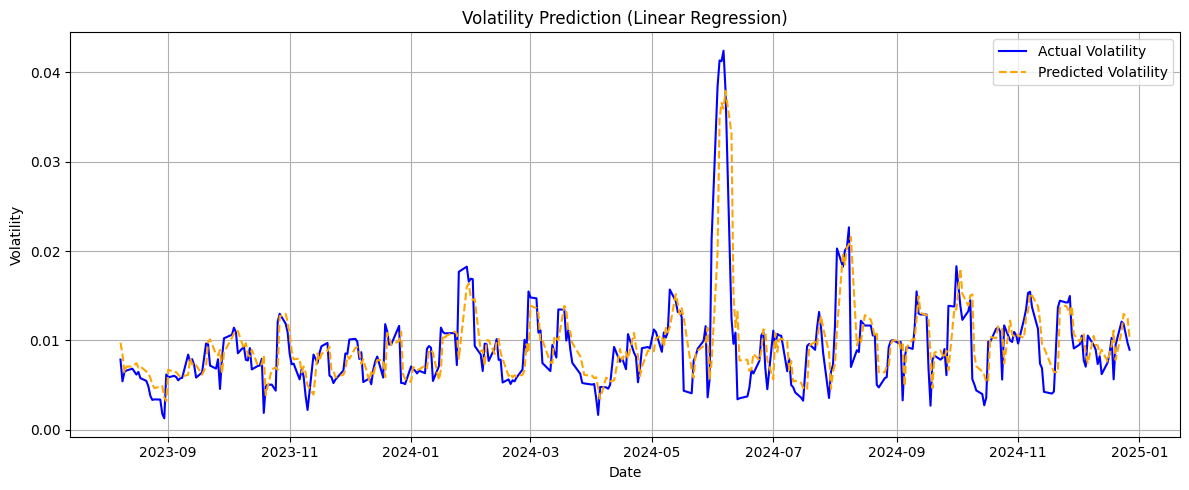

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Volatility', color='orange', linestyle='--')
plt.title("Volatility Prediction (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Features and target
X = df.drop(columns=['Portfolio_Return', 'target_volatility'])
y = df['target_volatility']

# Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


#Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Evaluation
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f"Random Forest — R²: {rf_r2:.3f}, MAE: {rf_mae:.6f}")


#Train XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Evaluation
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost — R²: {xgb_r2:.3f}, MAE: {xgb_mae:.6f}")

Random Forest — R²: 0.852, MAE: 0.002583
XGBoost — R²: 0.815, MAE: 0.002562


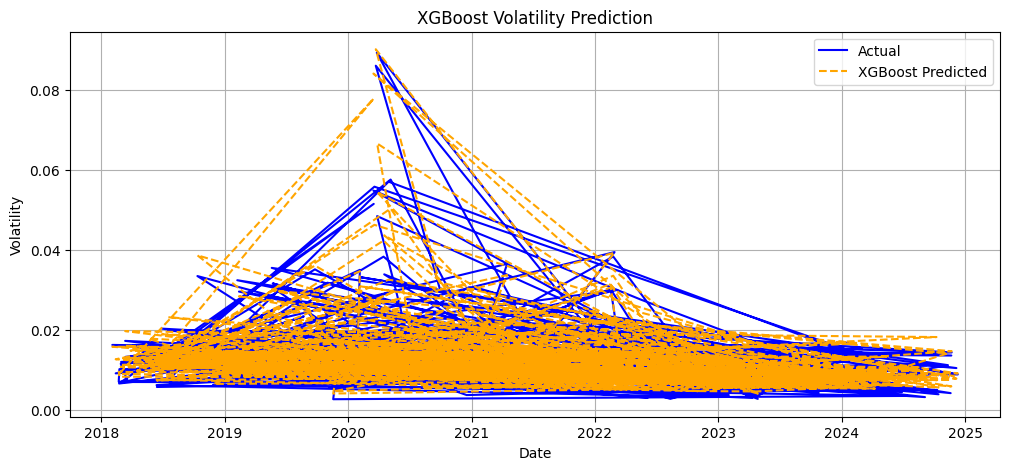

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, xgb_pred, label='XGBoost Predicted', color='orange', linestyle='--')
plt.title("XGBoost Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


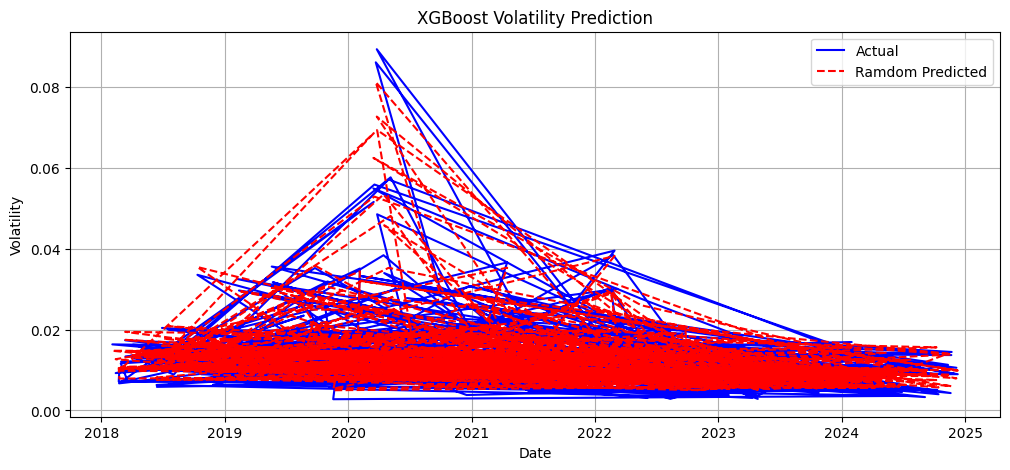

In [60]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, rf_pred, label='Ramdom Predicted', color='red', linestyle='--')
plt.title("XGBoost Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()